<a href="https://colab.research.google.com/github/danielmancovidales/Aplicaciones-en-finanzas/blob/main/Exploratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
# Librerias generales
import pandas as pd
import numpy as np
import re
from datetime import date
from datetime import datetime
# Librerias e visualización
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
# Lectura de base de datos filtrado
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df_filtrado= pd.read_csv('/content/drive/MyDrive/analitica3/Financiera/data_completa.csv')
df_filtrado.drop(['Unnamed: 0'],axis=1, inplace=True)

In [78]:
df_filtrado.head(5)

,mes_pago,asegurado_id,reclamacion,diagnostico_codigo,diagnostico_desc,eventos,valor_pagado,mujer,fechanacimiento,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,fecha_inicio,fecha_cancelacion,fecha_fin
0,2018-03-01,4834968,examenes de diagnostico,z011,examen de oídos y de la audición,1,495341.34,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
1,2018-04-01,4834968,laboratorio clinico,9,diagnóstico pendiente,15,717708.28,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
2,2018-03-01,4834968,consulta externa,9,diagnóstico pendiente,1,427837.35,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
3,2018-05-01,4834968,examenes de diagnostico,9,diagnóstico pendiente,1,496955.56,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31
4,2018-11-01,4834968,consulta externa,9,diagnóstico pendiente,2,523223.42,0,1969-10-30,cali,0,0,1,0,0,95576925,2018-01-01,2019-12-31,2019-12-31


# **Transformaciones de variables**

In [79]:
#Se cambia la variable mujer por genero donde 1 será genero femenino y 0 será masculino
df_filtrado["genero"] = df_filtrado["mujer"].rename("genero")
#df_filtrado['genero'] = df_filtrado['mujer'].replace({0: 'hombre', 1: 'mujer'})

#Eliminación
df_filtrado = df_filtrado.drop(["mujer"], axis=1)
df_filtrado.head(2)

# redondeo
df_filtrado['valor_pagado']=df_filtrado['valor_pagado'].round(2)

## eliminacion de la columna mes pago
df_filtrado = df_filtrado.drop('mes_pago', axis=1)

In [80]:
#Consulta para saber qué valores tiene la variable genero
df_filtrado["genero"].value_counts()

genero
 1    2391762
 0    1389638
-1         36
Name: count, dtype: int64

In [81]:
#Se eliminan los registros "-1" ya que sólo se tomarán los géneros 1 para F y 0 para M
df_filtrado = df_filtrado.drop(df_filtrado.loc[df_filtrado['genero'] == -1].index)
df_filtrado["genero"].value_counts()

genero
1    2391762
0    1389638
Name: count, dtype: int64

La variable de "fechanacimiento" puede servir para calcular la edad de los afiliados de acuerdo al supuesto de que las bases de datos fueron tomadas alrededor del 2018-2019, por lo tanto se va a calcular como los años transcurridos entre la fecha de nacimiento y la fecha de inicio a la afiliación.

In [82]:
#Convertir la fecha de nacimiento en una variable de edad
df_filtrado['fecha_inicio'] = pd.to_datetime(df_filtrado['fecha_inicio'], format='%Y-%m-%d')
df_filtrado['fechanacimiento'] = pd.to_datetime(df_filtrado['fechanacimiento'], format='%Y-%m-%d')
df_filtrado['edad'] = (df_filtrado['fecha_inicio'] - df_filtrado['fechanacimiento']).dt.days // 365

#Eliminación de las fechas
df_filtrado = df_filtrado.drop(["fecha_inicio", "fechanacimiento"], axis=1)
df_filtrado.head(5)

,asegurado_id,reclamacion,diagnostico_codigo,diagnostico_desc,eventos,valor_pagado,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,fecha_cancelacion,fecha_fin,genero,edad
0,4834968,examenes de diagnostico,z011,examen de oídos y de la audición,1,495341.34,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48
1,4834968,laboratorio clinico,9,diagnóstico pendiente,15,717708.28,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48
2,4834968,consulta externa,9,diagnóstico pendiente,1,427837.35,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48
3,4834968,examenes de diagnostico,9,diagnóstico pendiente,1,496955.56,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48
4,4834968,consulta externa,9,diagnóstico pendiente,2,523223.42,cali,0,0,1,0,0,95576925,2019-12-31,2019-12-31,0,48


In [83]:
### se haya el valor unitario de la reclamacion, se divide el valor pagado x el numero de eventos para saber cuanto costo cada tipo de reclamacion realizada.
df_filtrado['valor_unitario_reclamacion'] = np.where(df_filtrado['eventos'] != 0, df_filtrado['valor_pagado'] / df_filtrado['eventos'], df_filtrado['valor_pagado'])

#Cons(ulta para saber qué datos tiene la variable diagnostico_codigo
df_filtrado['diagnostico_codigo'].value_counts()


diagnostico_codigo
9       3129154
z017     119923
z108      24590
e039      22271
i10x      12112
         ...   
e507          1
k287          1
g418          1
d52x          1
q45x          1
Name: count, Length: 5823, dtype: int64

In [84]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3781400 entries, 0 to 3781435
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   asegurado_id                int64  
 1   reclamacion                 object 
 2   diagnostico_codigo          object 
 3   diagnostico_desc            object 
 4   eventos                     int64  
 5   valor_pagado                float64
 6   ciudad                      object 
 7   cancer                      int64  
 8   epoc                        int64  
 9   diabetes                    int64  
 10  hipertension                int64  
 11  enf_cardiovascular          int64  
 12  poliza_asegurado_id         int64  
 13  fecha_cancelacion           object 
 14  fecha_fin                   object 
 15  genero                      int64  
 16  edad                        int64  
 17  valor_unitario_reclamacion  float64
dtypes: float64(2), int64(10), object(6)
memory usage: 548.1+ MB


In [85]:
#Consulta para saber cuántas variables hay por cada tipo
df_filtrado.dtypes.value_counts()

int64      10
object      6
float64     2
Name: count, dtype: int64

# **Exploración**

In [86]:
df_filtrado['valor_unitario_reclamacion'].value_counts()

#### se puede analizar el tipo de diagnistico y el valor unitario por reclamacion, las cantidades de eventos y el valor pagado por el total de ellos
costo_diagn=df_filtrado[['reclamacion','diagnostico_codigo','diagnostico_desc','valor_unitario_reclamacion','eventos','valor_pagado']]
costo_diagn=costo_diagn.sort_values(by='eventos', ascending=False)
costo_diagn.head(5)

### los eventos mas repetitivos fueron de reclamaciones de fisioterapia

,reclamacion,diagnostico_codigo,diagnostico_desc,valor_unitario_reclamacion,eventos,valor_pagado
369712,fisioterapia ilimitada,9,diagnóstico pendiente,24005.34,279,6697490.35
369730,fisioterapia ilimitada,9,diagnóstico pendiente,27656.45,254,7024737.95
1002256,fisioterapia ilimitada,9,diagnóstico pendiente,2293.89,224,513831.56
3691890,fisioterapia ilimitada,9,diagnóstico pendiente,3476.23,220,764770.30
2645147,fisioterapia ilimitada,9,diagnóstico pendiente,4856.23,215,1044088.59


In [87]:
#Se consultan las variables numéricas para ver si alguna puede ser considerada como categórica
df_filtrado.select_dtypes(include=['int64'])

,asegurado_id,eventos,cancer,epoc,diabetes,hipertension,enf_cardiovascular,poliza_asegurado_id,genero,edad
0,4834968,1,0,0,1,0,0,95576925,0,48
1,4834968,15,0,0,1,0,0,95576925,0,48
2,4834968,1,0,0,1,0,0,95576925,0,48
3,4834968,1,0,0,1,0,0,95576925,0,48
4,4834968,2,0,0,1,0,0,95576925,0,48
...,...,...,...,...,...,...,...,...,...,...
3781431,25333920,1,0,0,0,0,0,189568131,0,30
3781432,17044022,1,0,0,0,0,0,94128351,1,36
3781433,52163564,1,0,0,0,0,0,101267369,1,11
3781434,48242859,1,0,0,0,0,0,175057169,0,15


Las variables asegurado_id, poliza_asegurado_id y edad pueden ser tomadas como categóricas por lo que se cambia su naturaleza a tipo Object

In [88]:
#Cambio a tipo object
df_filtrado[["asegurado_id", "poliza_asegurado_id", "edad"]] = df_filtrado[["asegurado_id", "poliza_asegurado_id", "edad"]].astype(object)
# Se separan las variables categoricas
categoricas= df_filtrado.select_dtypes(include=['object'])
# Se separan las variables numericas
columnas_a_eliminar = df_filtrado.columns.intersection(categoricas.columns)

numericas = df_filtrado.drop(columns=columnas_a_eliminar)

**Numéricas**

In [89]:
df_filtrado['cantidad_enfermedades']=df_filtrado['cancer'] + df_filtrado['epoc'] + df_filtrado['diabetes'] + df_filtrado['hipertension'] + df_filtrado['enf_cardiovascular']
# Agrupar por 'id' y calcular el valor máximo y mínimo de 'valor_pagado'
asegu_event=df_filtrado.groupby('asegurado_id')['eventos'].agg(['sum']).reset_index()  ### nos indica cuantos eventos hubo por asegurado
asegu_event = asegu_event.rename(columns={'sum': 'cantidad_eventos'})

enfer_id = df_filtrado[['asegurado_id','cantidad_enfermedades']]
enfer_id= enfer_id.drop_duplicates(subset=['asegurado_id']).reset_index(drop=True)

costos_totales= df_filtrado.groupby('asegurado_id')['valor_pagado'].agg(['sum']).reset_index()
costos_totales = costos_totales.rename(columns={'sum': 'total_valor_pagado'})


df_unido = pd.merge(asegu_event, enfer_id, on='asegurado_id')
df_unido_1=pd.merge(df_unido,costos_totales, on = 'asegurado_id')




In [90]:
df_unido.head(3)

,asegurado_id,cantidad_eventos,cantidad_enfermedades
0,738284,22,0
1,738288,24,0
2,738294,19,0


In [91]:
df_unido_1.head(3)

,asegurado_id,cantidad_eventos,cantidad_enfermedades,total_valor_pagado
0,738284,22,0,3020043.35
1,738288,24,0,8109891.08
2,738294,19,0,6620830.82


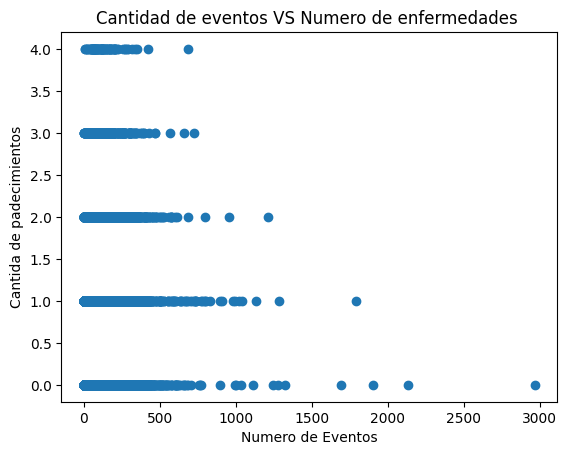

In [92]:
#### Grafica para ver la relacion de la Cantidad de eventos por la cantidad de enfermedades que padece el paciente
x = df_unido['cantidad_eventos']
y = df_unido['cantidad_enfermedades']
# Crea el diagrama de dispersión
plt.scatter(x, y)

# Agrega etiquetas y título
plt.xlabel('Numero de Eventos')
plt.ylabel('Cantida de padecimientos')
plt.title('Cantidad de eventos VS Numero de enfermedades ')

# Muestra el diagrama
plt.show()

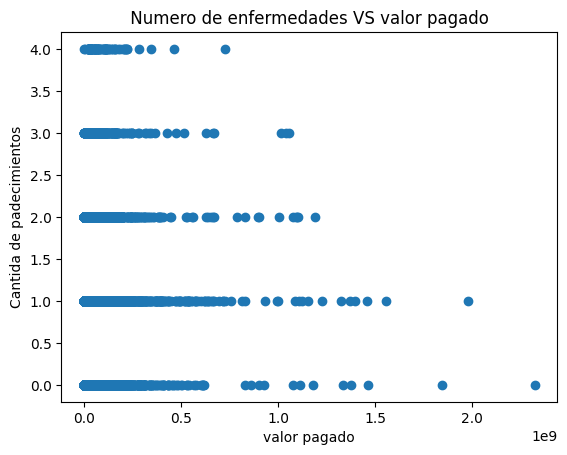

In [93]:
#### Grafica para ver la relacion de la Cantidad de eventos por la cantidad de enfermedades que padece el paciente
x = df_unido_1['total_valor_pagado']
y = df_unido_1['cantidad_enfermedades']
# Crea el diagrama de dispersión
plt.scatter(x, y)

# Agrega etiquetas y título
plt.xlabel('valor pagado')
plt.ylabel('Cantida de padecimientos')
plt.title(' Numero de enfermedades VS valor pagado ')

# Muestra el diagrama
plt.show()

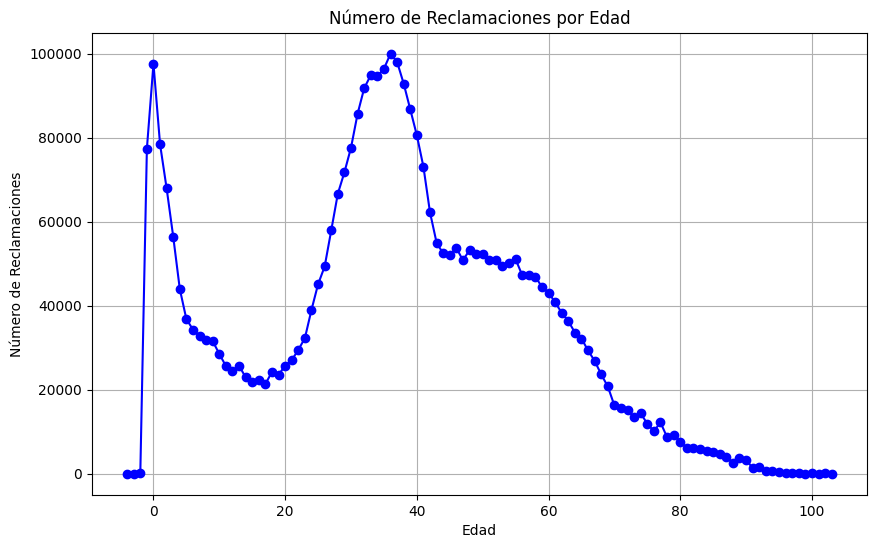

In [94]:
edades=df_filtrado.groupby('edad')['reclamacion'].agg(['count']).reset_index()
edades
# Crear el diagrama de líneas
plt.figure(figsize=(10, 6))
plt.plot(edades['edad'], edades['count'], marker='o', linestyle='-', color='b')

# Añadir título y etiquetas
plt.title('Número de Reclamaciones por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de Reclamaciones')
plt.grid(True)

De las gráficas se puede notar que:

-El número de eventos no es mayor a 35 o 40.

-Un porcentaje muy bajo de los afiliados presentan enfermedades como cáncer, EPOC, enfermedad cardiovascular e hipertensión; la diabetes es la que más se presenta en los afiliados. Sin embargo, el procentaje de afiliados que presentan enfermedades es muy bajo.

-La proporción de mujeres es mayor a la de hombres.

Por el momento se decide no eliminar ninguna variable ya que la cantidad que se tiene de ellas es baja y podría sesgar demasiado los resultados de los modelos posteriores.


In [95]:
pd.set_option('display.float_format', '{:.2f}'.format)
# Agrupar por 'ciudad' y calcular el valor máximo y mínimo de 'valor_pagado'
df3 = df_filtrado.groupby('ciudad')['valor_pagado'].agg(['max', 'min']).reset_index()

# Mostrar el DataFrame resultante
print(df3)

            ciudad           max       min
0     barranquilla  136566716.46 363268.32
1           bogota  878352590.99 363269.78
2             cali 1977985552.70 216520.52
3        cartagena  822035890.70 102000.00
4         medellin  493533776.18 363268.32
5  sin información   17574478.38 369155.84


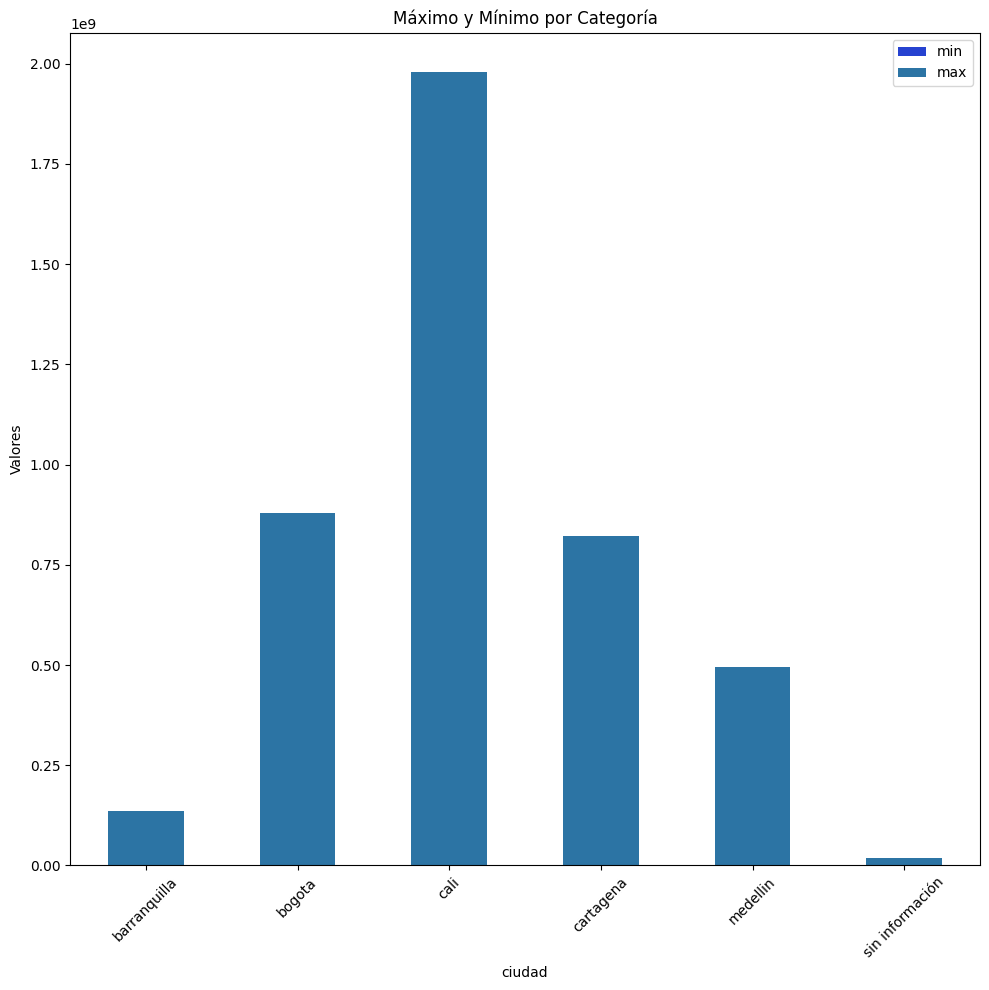

In [96]:
pd.set_option('display.float_format', '{:.2f}'.format)
# Gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 10))
c=['#2642D0','#2C74A4']
df3.set_index('ciudad')[['min', 'max']].plot(kind='bar', stacked=True, ax=ax, color=c)
ax.set_ylabel('Valores')
ax.set_title('Máximo y Mínimo por Categoría')
plt.xticks(rotation=45)  # Para que las etiquetas de las ciudades sean más legibles
plt.tight_layout()  # Para ajustar el diseño y que todo se vea correctamente
plt.show()

**Categóricas**

In [97]:
porcentaje=df_filtrado['reclamacion'].value_counts(normalize=True)*100
x=porcentaje.head(9)
x

reclamacion
consulta externa                                38.01
examenes de diagnostico                         20.92
laboratorio clinico                             15.67
consulta de urgencias                           11.10
cirugia ambulatoria por enfermedad               3.19
fisioterapia ilimitada                           2.97
tratamientos especificos                         1.57
tratamiento medico ambulatorio por accidentes    1.18
consultas prenatales                             1.02
Name: proportion, dtype: float64

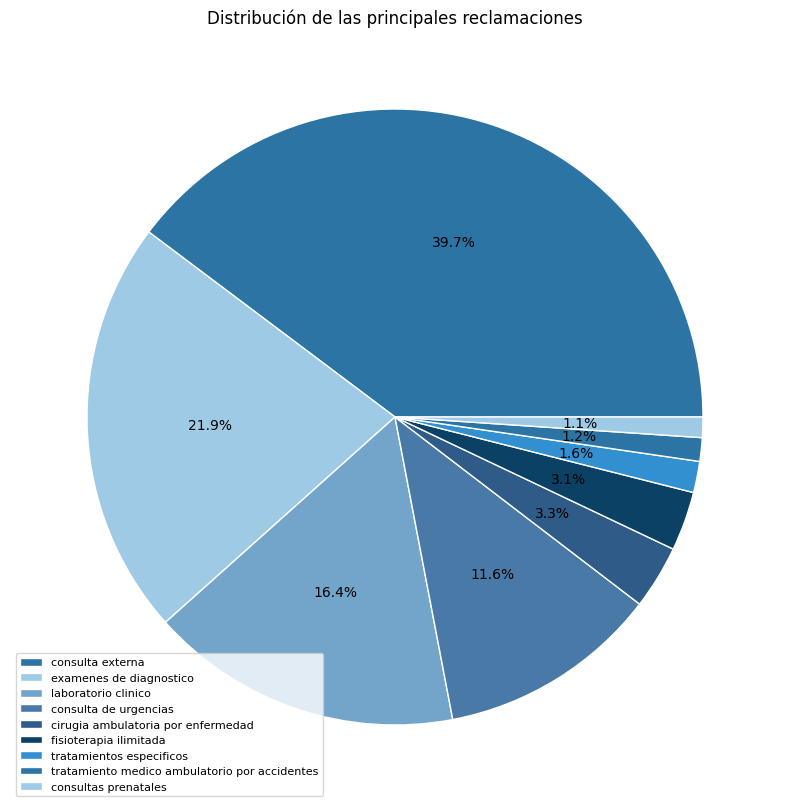

In [98]:
# Calcular los porcentajes y seleccionar las primeras 9 categorías
porcentaje = df_filtrado['reclamacion'].value_counts(normalize=True) * 100
x = porcentaje.head(9)

# Definir los colores
colores = ['#2C74A4', '#9FCAE6', '#73A4CA', '#497AA7', '#2E5B88','#0B4165','#3290D0']

# Crear el diagrama de torta con los colores definidos
fig, ax = plt.subplots(figsize=(10, 10))
pie = plt.pie(x, colors=colores, autopct='%1.1f%%',wedgeprops = {"linewidth": 1, "edgecolor": "white"})

# Crear una leyenda personalizada utilizando un bucle sobre las etiquetas
labels = x.index
plt.legend(pie[0], labels, loc='lower left', fontsize=8)
# Agregar título al diagrama de torta
plt.title('Distribución de las principales reclamaciones')

plt.show()

In [99]:
# Función para diagrama de barras

def plot_category_counts(data, column_name):
    counts = data[column_name].value_counts()
    m = pd.DataFrame({column_name: counts.index, 'Count': counts.values})
    m = m.sort_values(by=column_name)
    sns.barplot(data=m, y=column_name, x='Count')
    plt.show()

Se puede notar claramente que algunas variables tienen una cantidad de datos diferente que impide analizar su distribución. De las que sí se logra mostrar sus valores se identifica que:

-La consulta externa, exámenes de diagnóstico, laboratorio clínico y consulta de urgencias son las reclamaciones más comunes.

-Cali es la ciudad que más afiliado tiene seguida de Cartagena y Bogotá en medidas muy parecidas y siendo Medellín y Barranquilla las de menor número de afiliados.

In [100]:
### se realizara la tarifacion para cirugias ambulatorias por enfermedad

final = df_filtrado[df_filtrado['reclamacion'] == 'cirugia ambulatoria por enfermedad']
final=final.drop(columns=['fecha_cancelacion','poliza_asegurado_id','fecha_cancelacion','fecha_fin','valor_unitario_reclamacion','diagnostico_desc'])

In [101]:
final.head(5)

,asegurado_id,reclamacion,diagnostico_codigo,eventos,valor_pagado,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,genero,edad,cantidad_enfermedades
11,4834968,cirugia ambulatoria por enfermedad,b977,1,715463.04,cali,0,0,1,0,0,0,48,1
17,4834968,cirugia ambulatoria por enfermedad,b977,1,730871.55,cali,0,0,1,0,0,0,48,1
46,14915125,cirugia ambulatoria por enfermedad,z961,1,2323818.92,cali,0,0,0,0,0,1,34,0
47,14915125,cirugia ambulatoria por enfermedad,h358,1,2211963.35,cali,0,0,0,0,0,1,34,0
48,14915125,cirugia ambulatoria por enfermedad,z961,1,1354615.74,cali,0,0,0,0,0,1,34,0


In [102]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120737 entries, 11 to 3781336
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   asegurado_id           120737 non-null  object 
 1   reclamacion            120737 non-null  object 
 2   diagnostico_codigo     120737 non-null  object 
 3   eventos                120737 non-null  int64  
 4   valor_pagado           120737 non-null  float64
 5   ciudad                 120735 non-null  object 
 6   cancer                 120737 non-null  int64  
 7   epoc                   120737 non-null  int64  
 8   diabetes               120737 non-null  int64  
 9   hipertension           120737 non-null  int64  
 10  enf_cardiovascular     120737 non-null  int64  
 11  genero                 120737 non-null  int64  
 12  edad                   120737 non-null  object 
 13  cantidad_enfermedades  120737 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memo

In [103]:
final['diag_codig'] = final['diagnostico_codigo'].apply(lambda x: x[:2])
final.head(2)

,asegurado_id,reclamacion,diagnostico_codigo,eventos,valor_pagado,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,genero,edad,cantidad_enfermedades,diag_codig
11,4834968,cirugia ambulatoria por enfermedad,b977,1,715463.04,cali,0,0,1,0,0,0,48,1,b9
17,4834968,cirugia ambulatoria por enfermedad,b977,1,730871.55,cali,0,0,1,0,0,0,48,1,b9


In [104]:

### realizando algunas investigaciones sobre las enfermedades mas frecuentes en los colombianos, se encontro que las principales enfermedades son; 1. Enfermedades isquémicas del corazón
###2. Enfermedades cerebrovasculares. 3. Enfermedades respiratorias crónicas. 4. Enfermedades hipertensivas
### para ellos entonces vamos a tarifar cirugias ambulatorias de las categorias de enfermedades ya mencionadas

# segun el dame en el análisis de la serie 2013 a 2023 por sexo y grandes grupos de la lista 6/67, se observa que las enfermedades del sistema
#circulatorio representan el mayor volumen de casos para ambos sexos.


final['diag_codig'] = final['diag_codig'].str.lower()
# Crear la columna 'clasifica_diagn' con valores predeterminados
final['clasifica_diagn'] = None

##Crear o asignar a la columna 'clasifica_diagn' basado en la condición
final.loc[final['diag_codig'].between('i0', 'i9'), 'clasifica_diagn'] = 'enf_apar_cir'  ### 1
final.loc[final['diag_codig'].between('c0', 'd4'), 'clasifica_diagn'] = 'neoplasia' ### 2
final.loc[final['diag_codig'].between('j0', 'j9'), 'clasifica_diagn'] = 'enf_apar_resp' ### 3
final.loc[final['diag_codig'].between('e0', 'e8'), 'clasifica_diagn'] = 'enf_endo _nut_y_met' ##4


chicos tenemos que traer las columanss que vamos a utlizar agrupandolo por las enfermedades que vamos a tarifar las cuales son las anrteriores y luego cambiar esas categorias a numeros para haccer las correlaciones y lo demas

In [105]:
final['clasifica_diagn'].value_counts()

clasifica_diagn
neoplasia              18886
enf_apar_resp           8314
enf_apar_cir            3220
enf_endo _nut_y_met      412
Name: count, dtype: int64

In [106]:
valores_filtrar = [
    'enf_apar_cir',
    'neoplasia',
    'enf_apar_resp',
    'enf_endo _nut_y_met' ]


# Filtra el DataFrame
final2 = final[final['clasifica_diagn'].isin(valores_filtrar)]
final2.head(2)

,asegurado_id,reclamacion,diagnostico_codigo,eventos,valor_pagado,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,genero,edad,cantidad_enfermedades,diag_codig,clasifica_diagn
103,21442420,cirugia ambulatoria por enfermedad,d233,1,715463.04,cali,0,0,0,0,0,1,27,0,d2,neoplasia
453,2973589,cirugia ambulatoria por enfermedad,d231,1,691983.39,cali,0,1,0,0,0,0,42,1,d2,neoplasia


In [107]:
final2 = final2.drop(columns=['asegurado_id', 'reclamacion', 'diagnostico_codigo','diag_codig'])

In [108]:
final2

,eventos,valor_pagado,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,genero,edad,cantidad_enfermedades,clasifica_diagn
103,1,715463.04,cali,0,0,0,0,0,1,27,0,neoplasia
453,1,691983.39,cali,0,1,0,0,0,0,42,1,neoplasia
458,1,737639.56,cali,0,1,0,0,0,0,42,1,neoplasia
481,1,1084533.75,medellin,0,0,0,0,0,0,29,0,neoplasia
936,1,576052.63,bogota,0,0,0,0,0,0,31,0,neoplasia
...,...,...,...,...,...,...,...,...,...,...,...,...
3779515,1,2632050.94,cartagena,0,0,0,0,0,0,33,0,enf_endo _nut_y_met
3779682,1,444949.61,cali,0,0,0,0,0,0,46,0,neoplasia
3779683,1,444949.61,cali,0,0,0,0,0,0,45,0,neoplasia
3780641,1,2517232.52,cali,0,1,0,0,0,1,36,1,neoplasia


In [109]:
## para la realizacion del matriz de correlacciones se tranformar columnas categoricas a numericas usando el metodo one hot enconding
# Usar Label Encoding
df_final2 = pd.get_dummies(final2, columns=['clasifica_diagn','ciudad'])
df_final2

,eventos,valor_pagado,cancer,epoc,diabetes,hipertension,enf_cardiovascular,genero,edad,cantidad_enfermedades,clasifica_diagn_enf_apar_cir,clasifica_diagn_enf_apar_resp,clasifica_diagn_enf_endo _nut_y_met,clasifica_diagn_neoplasia,ciudad_barranquilla,ciudad_bogota,ciudad_cali,ciudad_cartagena,ciudad_medellin,ciudad_sin información
103,1,715463.04,0,0,0,0,0,1,27,0,False,False,False,True,False,False,True,False,False,False
453,1,691983.39,0,1,0,0,0,0,42,1,False,False,False,True,False,False,True,False,False,False
458,1,737639.56,0,1,0,0,0,0,42,1,False,False,False,True,False,False,True,False,False,False
481,1,1084533.75,0,0,0,0,0,0,29,0,False,False,False,True,False,False,False,False,True,False
936,1,576052.63,0,0,0,0,0,0,31,0,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779515,1,2632050.94,0,0,0,0,0,0,33,0,False,False,True,False,False,False,False,True,False,False
3779682,1,444949.61,0,0,0,0,0,0,46,0,False,False,False,True,False,False,True,False,False,False
3779683,1,444949.61,0,0,0,0,0,0,45,0,False,False,False,True,False,False,True,False,False,False
3780641,1,2517232.52,0,1,0,0,0,1,36,1,False,False,False,True,False,False,True,False,False,False


In [113]:
# Se convierte a CSV
df_final2.to_csv('/content/drive/MyDrive/analitica3/Financiera/df_final2.csv', index=True)